In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import f_classif
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [200]:
data = pd.read_csv('healthcare_dataset.csv', delimiter=',', encoding='ISO-8859-1')
data = data.drop(columns=['Name', 'Doctor', 'Hospital'])
data = data.dropna().drop_duplicates()

In [201]:
print(f'\n{data.info()}\n, \n{data.describe()}, \n{data.isnull().sum()}')

<class 'pandas.core.frame.DataFrame'>
Index: 54966 entries, 0 to 55499
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 54966 non-null  int64  
 1   Gender              54966 non-null  object 
 2   Blood Type          54966 non-null  object 
 3   Medical Condition   54966 non-null  object 
 4   Date of Admission   54966 non-null  object 
 5   Insurance Provider  54966 non-null  object 
 6   Billing Amount      54966 non-null  float64
 7   Room Number         54966 non-null  int64  
 8   Admission Type      54966 non-null  object 
 9   Discharge Date      54966 non-null  object 
 10  Medication          54966 non-null  object 
 11  Test Results        54966 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 5.5+ MB

None
, 
                Age  Billing Amount   Room Number
count  54966.000000    54966.000000  54966.000000
mean      51.535185    25544.306284    

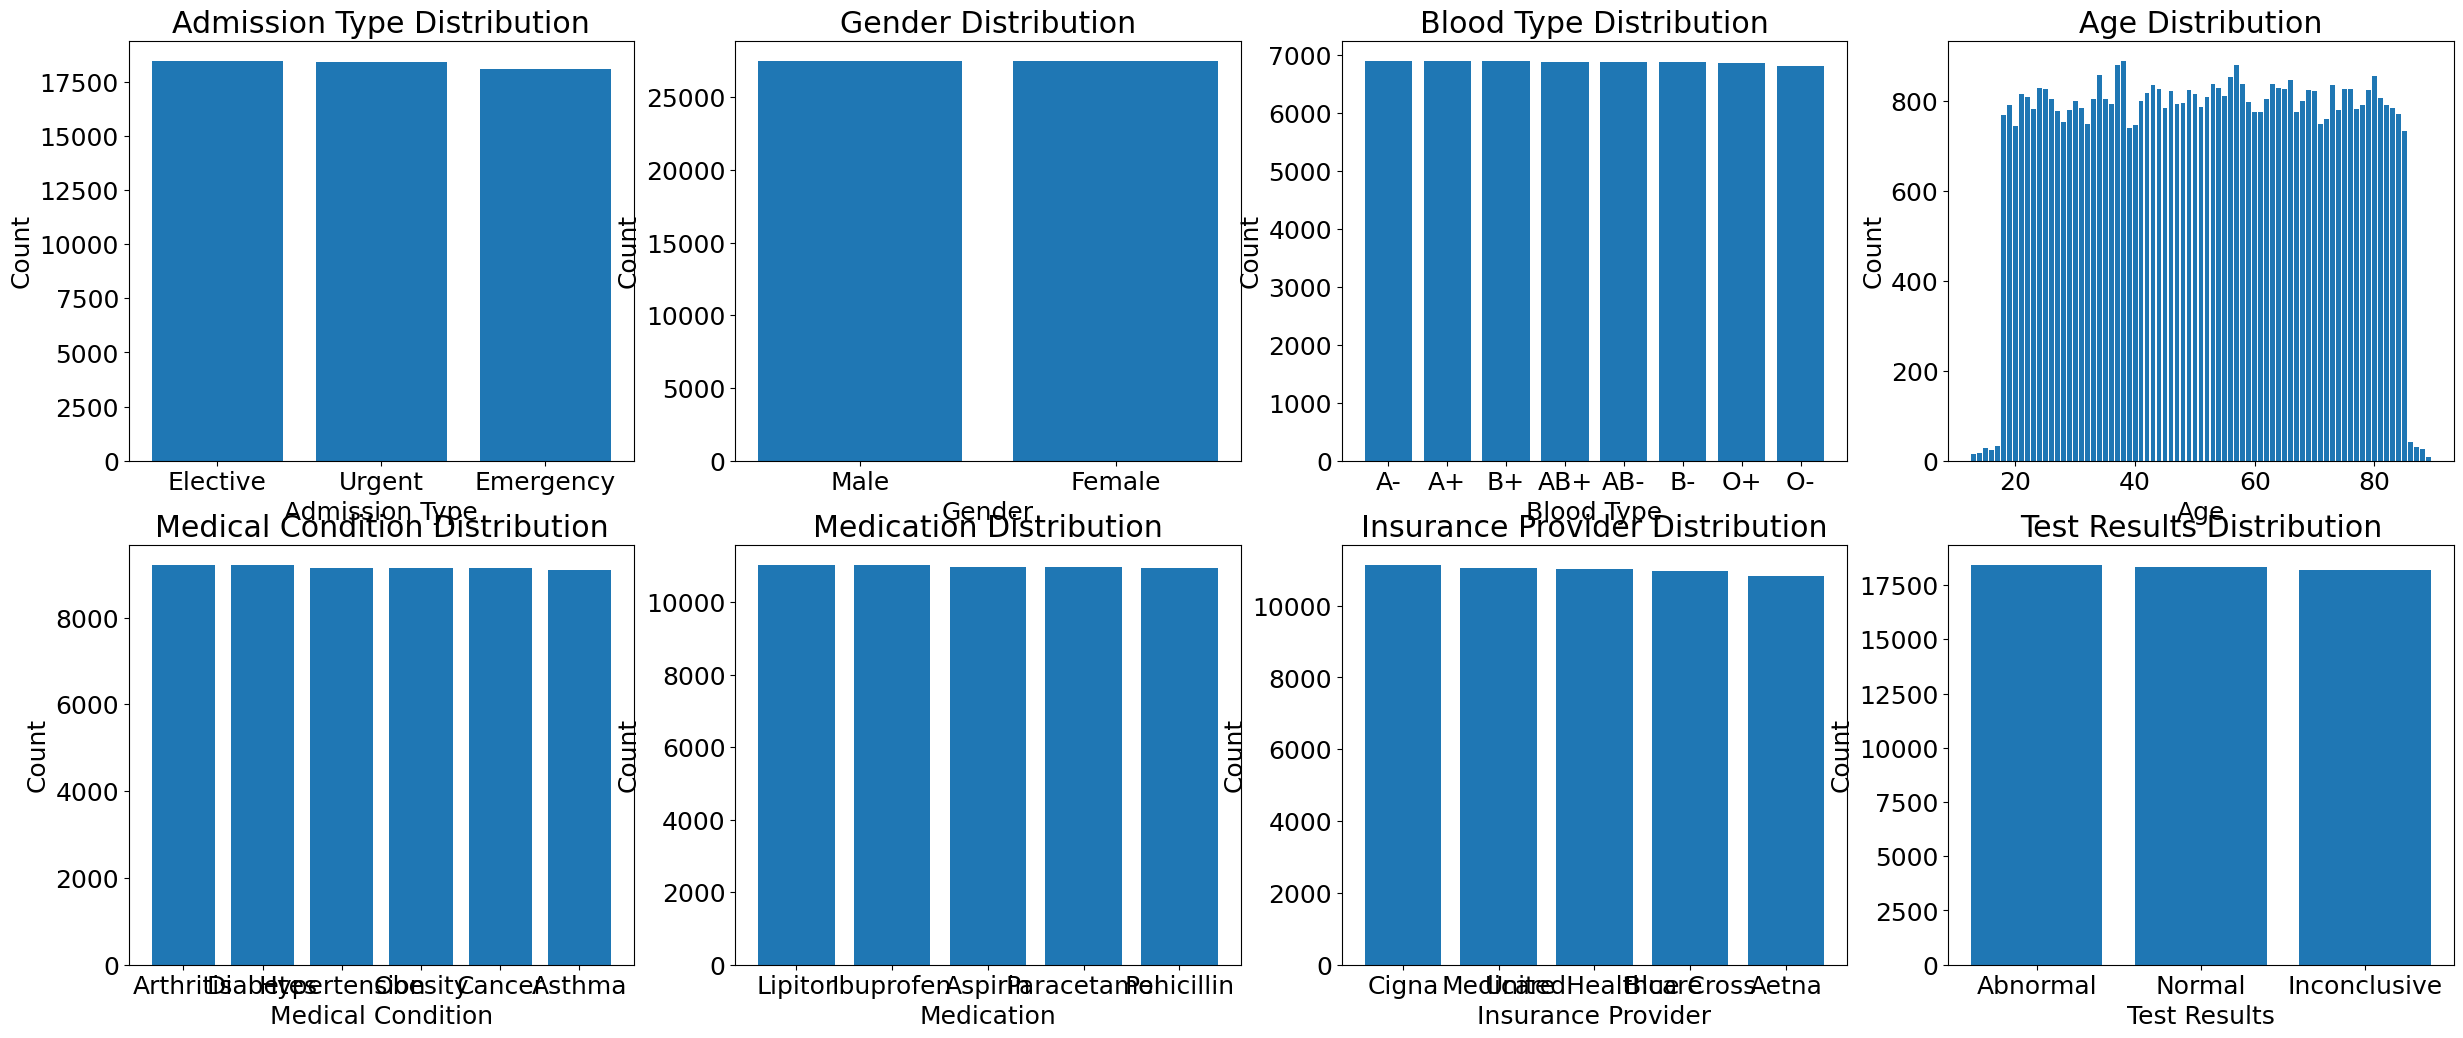

In [202]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(30, 12))

variables = ['Admission Type', 'Gender', 'Blood Type', 'Age', 'Medical Condition', 'Medication', 'Insurance Provider', 'Test Results']
for ax, var in zip(axs.flatten(), variables):
    counts = data[var].value_counts()
    ax.bar(counts.index, counts.values)
    ax.set_title(f'{var} Distribution')
    ax.set_ylabel('Count')
    ax.set_xlabel(var)

In [203]:
'''def group_rare_categories(column, threshold=0.01):
    counts = column.value_counts(normalize=True)
    return column.apply(lambda x: x if counts[x] > threshold else 'Other')

low_cardinality_cols = ['Gender', 'Blood Type', 'Medical Condition', 'Admission Type', 'Medication']
high_cardinality_cols = ['Insurance Provider']

for col in high_cardinality_cols:
    data[col] = group_rare_categories(data[col])'''

data['Date of Admission'] = pd.to_datetime(data['Date of Admission'])
data['Discharge Date'] = pd.to_datetime(data['Discharge Date'])
data['Length of Stay'] = (data['Discharge Date'] - data['Date of Admission']).dt.days
data = data.drop(['Date of Admission', 'Discharge Date'], axis=1)

## ANOVA Test for numerical variables

In [204]:
X = data[['Room Number', 'Billing Amount','Age','Length of Stay']]
y = data['Test Results']

f_values, p_values = f_classif(X, y)
anova_results = pd.DataFrame({'Feature': X.columns, 'F-Value': f_values, 'p-value': p_values})
anova_results = anova_results.sort_values(by='F-Value', ascending=False)

print("ANOVA F-Test Results:")
anova_results

ANOVA F-Test Results:


,Feature,F-Value,p-value
2,Age,1.883570,0.152056
1,Billing Amount,0.775072,0.460676
0,Room Number,0.476433,0.620997
3,Length of Stay,0.448304,0.638713


## Chi-Square test for categorical variables

In [205]:
categorical_cols = data.drop(columns=['Room Number', 'Billing Amount','Test Results','Age','Length of Stay'])

chi2_results = []
for feature in categorical_cols:
    contingency_table = pd.crosstab(data[feature], data['Test Results'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    chi2_results.append((feature, chi2, p))

chi2_df = pd.DataFrame(chi2_results, columns=['Feature', 'Chi-Square', 'P-Value'])
chi2_df.sort_values(by='P-Value', inplace=True)
chi2_df

,Feature,Chi-Square,P-Value
2,Medical Condition,13.271595,0.208881
0,Gender,2.184632,0.335439
3,Insurance Provider,9.034619,0.339384
4,Admission Type,1.648354,0.800076
5,Medication,3.851882,0.870234
1,Blood Type,8.001800,0.889232


## Model General Statistics

In [206]:
import statsmodels.api as sm

x2 = sm.add_constant(X_train)
model_train = sm.OLS(y_train, x2)
model_fit = model_train.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Test Results   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.035
Date:                Wed, 03 Jul 2024   Prob (F-statistic):              0.415
Time:                        21:46:27   Log-Likelihood:                -49717.
No. Observations:               40867   AIC:                         9.948e+04
Df Residuals:                   40842   BIC:                         9.970e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.4359      0.008     51.987      0.000       0.419       0.452
Age                   -0.0003      0.000     -1.503      0.133      -0.001    9.43e-05
Insurance Provider    -0.0022      0.003     -0.781      0.435      -0.008       0.003
Billing Amount     -1.933e-07   2.84e-07     -0.680      0.497   -7.51e-07    3.64e-07
Room Number         8.076e-06   3.51e-05      0.230      0.818   -6.08e-05    7.69e-05
Length of Stay         0.0005      0.000      1.040      0.298      -0.000       0.001
Female                 0.2130      0.006     36.473      0.000       0.202       0.224
Male                   0.2228      0.006     38.372      0.000       0.211       0.234
A+                     0.0513      0.011      4.755      0.000       0.030       0.072
A-                     0.0568      0.011      5.296      0.000       0.036       0.078
AB+                    0.0674      0.011      6.294      0.000       0.046       0.088
AB-                    0.0680      0.011      6.331      0.000       0.047       0.089
B+                     0.0378      0.011      3.549      0.000       0.017       0.059
B-                     0.0584      0.011      5.431      0.000       0.037       0.079
O+                     0.0474      0.011      4.388      0.000       0.026       0.069
O-                     0.0489      0.011      4.514      0.000       0.028       0.070
Arthritis              0.0596      0.009      6.517      0.000       0.042       0.078
Asthma                 0.0843      0.009      9.170      0.000       0.066       0.102
Cancer                 0.0699      0.009      7.644      0.000       0.052       0.088
Diabetes               0.0654      0.009      7.155      0.000       0.047       0.083
Hypertension           0.0924      0.009     10.121      0.000       0.075       0.110
Obesity                0.0643      0.009      7.041      0.000       0.046       0.082
Elective               0.1355      0.006     21.396      0.000       0.123       0.148
Emergency              0.1493      0.006     23.264      0.000       0.137       0.162
Urgent                 0.1511      0.006     23.812      0.000       0.139       0.164
Aspirin                0.0925      0.008     11.211      0.000       0.076       0.109
Ibuprofen              0.0779      0.008      9.434      0.000       0.062       0.094
Lipitor                0.0832      0.008     10.109      0.000       0.067       0.099
Paracetamol            0.0915      0.008     11.032      0.000       0.075       0.108
Penicillin             0.0908      0.008     10.997      0.000       0.075       0.107
==============================================================================
Omnibus:                   246146.906   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (J

In [207]:
low_cardinality_cols = ['Gender', 'Blood Type', 'Medical Condition', 'Admission Type', 'Medication']
high_cardinality_cols = ['Insurance Provider']

encoder = OneHotEncoder()
low_cardinality_cols_encoded = {}
encoder_names = []
for col in data[low_cardinality_cols]:
    low_cardinality_cols_encoded[col] = encoder.fit_transform(data[[col]]).toarray()
    encoder_names.extend(encoder.categories_)
column_names = [name for names in encoder_names for name in names]
encoded_arrays = [low_cardinality_cols_encoded[col] for col in low_cardinality_cols]
encoded_data = np.hstack(encoded_arrays)
encoded_df = pd.DataFrame(encoded_data, columns=column_names)

In [208]:
#data = pd.get_dummies(data, columns=low_cardinality_cols, drop_first=True)
#columns = ['Test Results','Age','Length of Stay','Billing Amount','Room Number']

In [209]:
label_encoders = {}
for col in high_cardinality_cols:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col])

label_encoder = LabelEncoder()
data['Test Results'] = label_encoder.fit_transform(data['Test Results'])

In [210]:
Cleaned_data = pd.concat([data.drop(columns=low_cardinality_cols), encoded_df ], axis=1).dropna()
Cleaned_data

,Age,Insurance Provider,Billing Amount,Room Number,Test Results,Length of Stay,Female,Male,A+,A-,...,Hypertension,Obesity,Elective,Emergency,Urgent,Aspirin,Ibuprofen,Lipitor,Paracetamol,Penicillin
0,30.0,1.0,18856.281306,328.0,2.0,2.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,62.0,3.0,33643.327287,265.0,1.0,6.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,76.0,0.0,27955.096079,205.0,2.0,15.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,28.0,3.0,37909.782410,450.0,0.0,30.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,43.0,0.0,14238.317814,458.0,0.0,20.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54960,81.0,4.0,22120.797267,433.0,2.0,25.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
54961,18.0,3.0,42745.133582,432.0,0.0,27.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
54962,14.0,1.0,32923.077365,199.0,1.0,25.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
54963,44.0,2.0,18851.361794,178.0,2.0,20.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [211]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(Cleaned_data.drop(columns='Test Results'))

features = pd.DataFrame(scaled_data, columns=Cleaned_data.drop(columns='Test Results').columns)

pca = PCA(n_components=0.9, random_state=42)
pca_data = pca.fit_transform(features)
pca_data

array([[ 1.53203441, -1.21316536, -1.0682531 , ...,  0.87282413,
         1.05467433, -0.67765598],
       [ 1.29685672, -0.32966928,  1.82327081, ...,  0.39284407,
         0.28561656, -0.4430389 ],
       [-1.4782864 , -0.32072696,  1.73862194, ..., -1.66332201,
         0.26919504, -0.79291851],
       ...,
       [-1.45240096,  1.69905878, -0.56060371, ..., -0.26279799,
         0.92741427,  1.71695113],
       [-1.28471045, -1.3680606 , -1.09099046, ..., -0.58726617,
         0.21714362,  0.9668188 ],
       [-1.36266942, -1.38124768, -1.08928376, ...,  0.05203645,
         0.83772596,  0.6096856 ]])

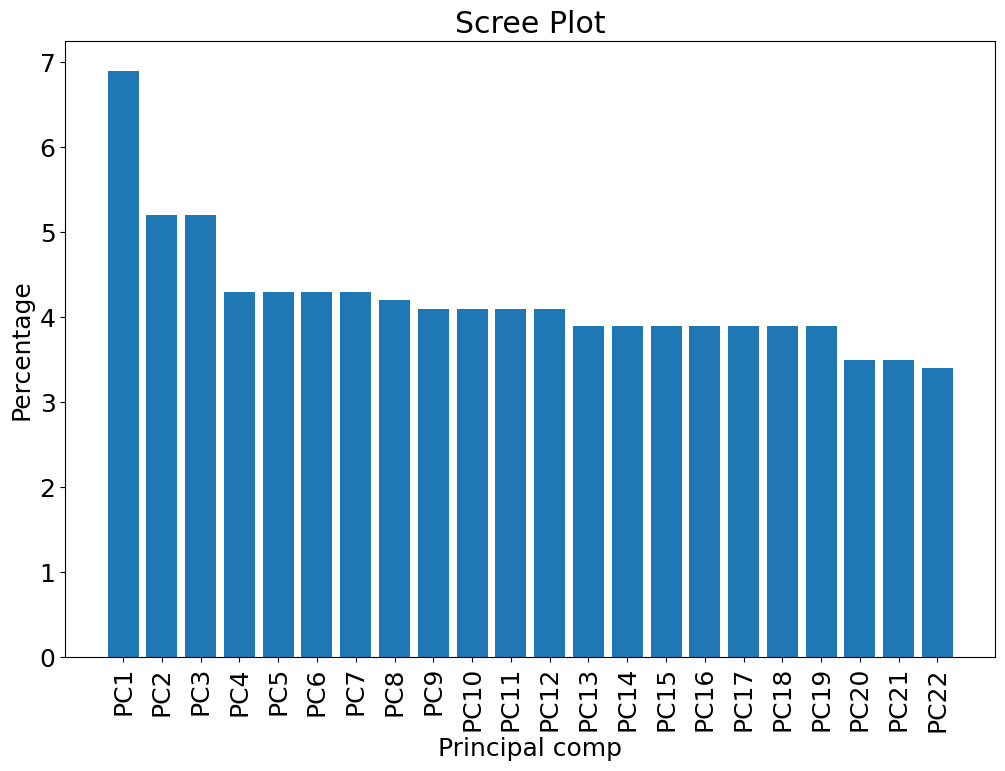

In [212]:
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]

plt.figure(figsize=(12,8))
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)

plt.ylabel('Percentage')
plt.xlabel('Principal comp')
plt.title('Scree Plot')
plt.xticks(rotation=90)
plt.show()

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [29] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [23] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [29] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[23]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


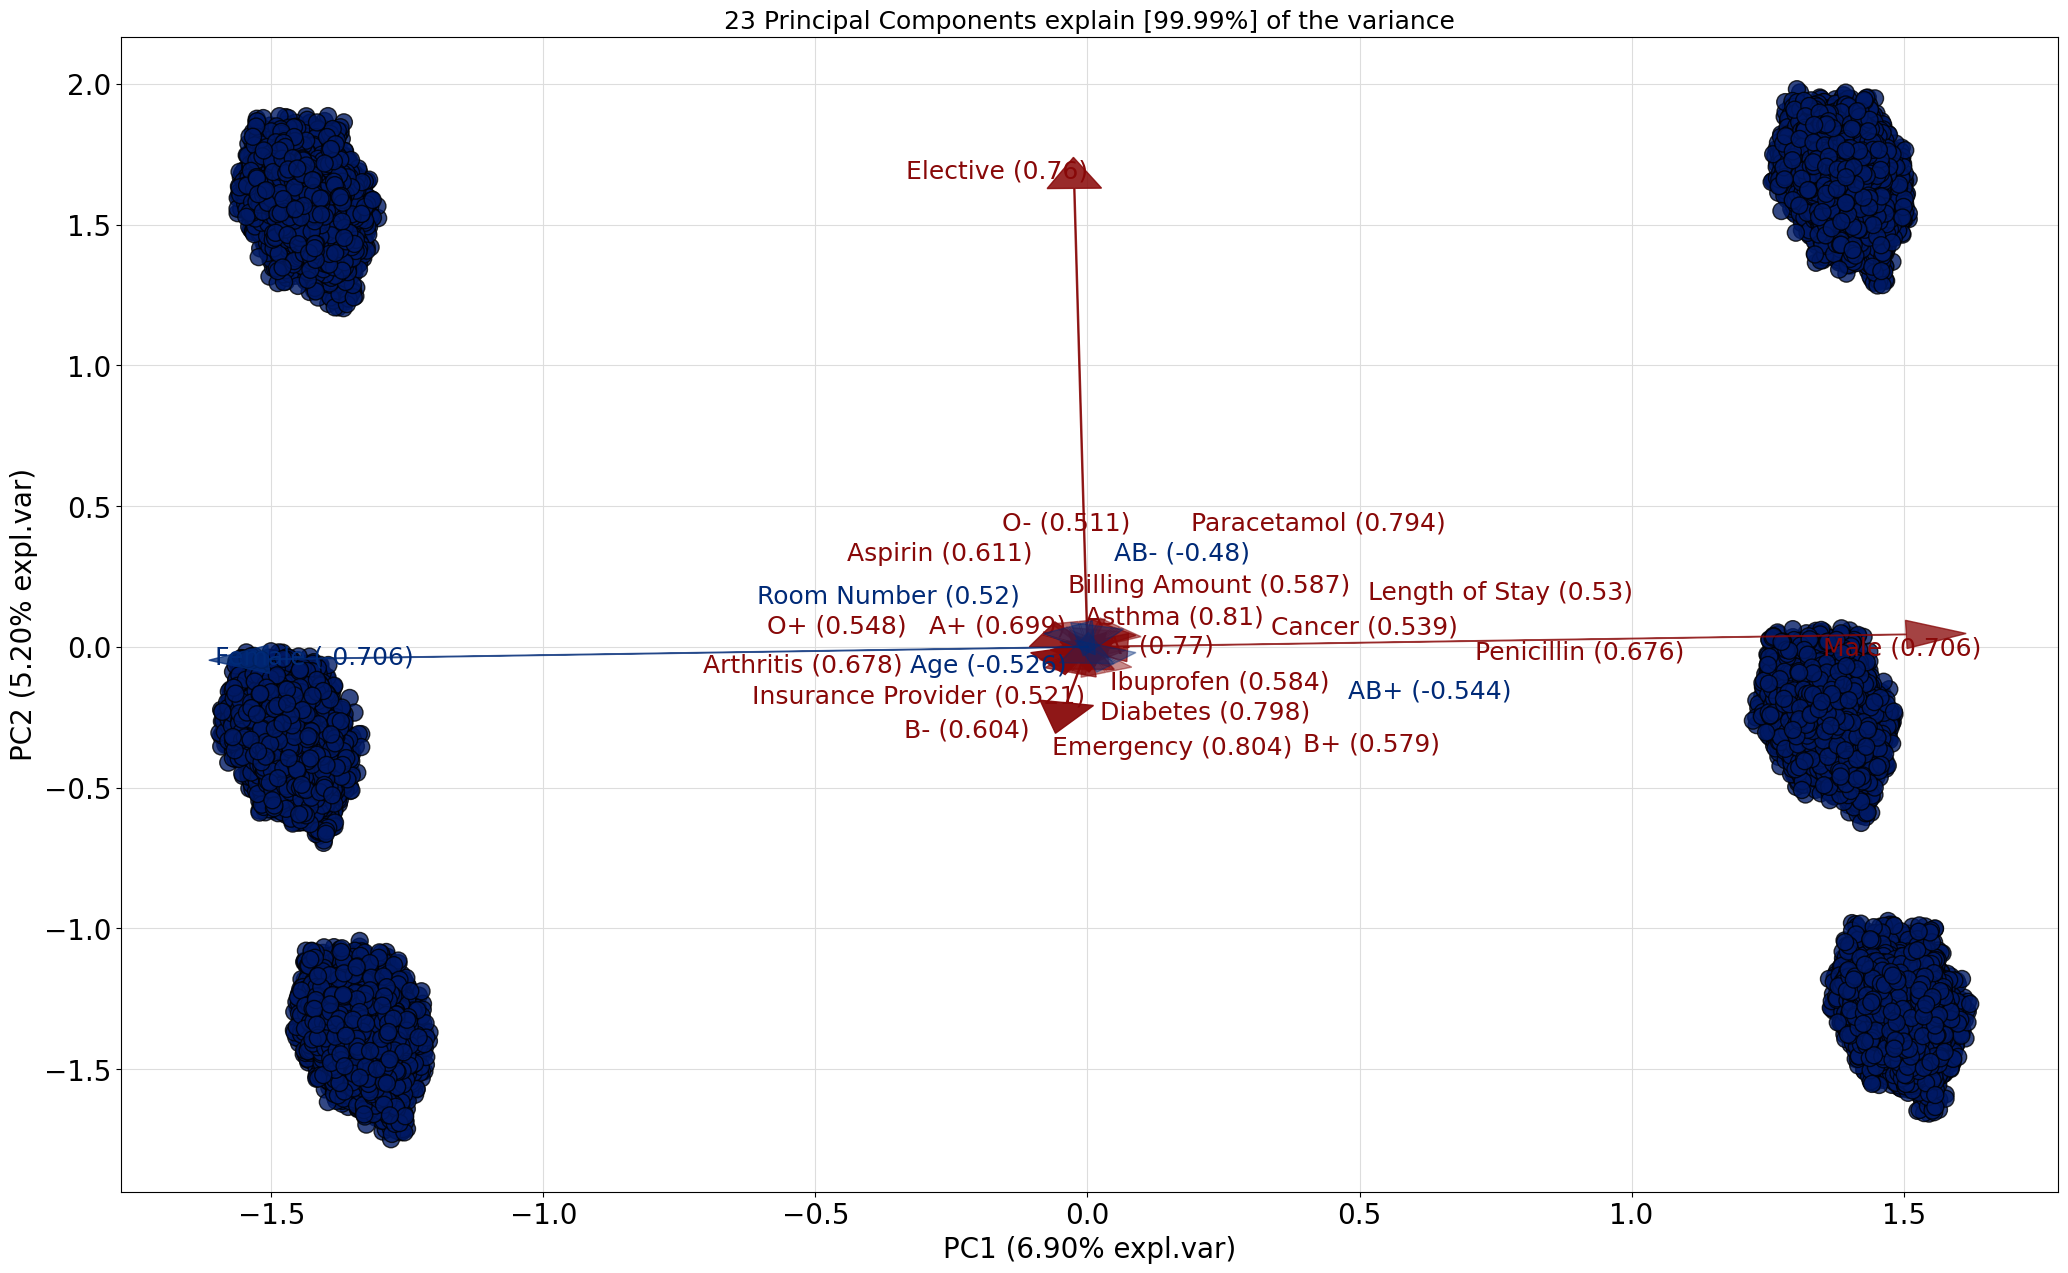

In [213]:
from pca import pca
#features = Cleaned_data.drop(columns='Test Results')
scaled_yield_df = pd.DataFrame(features, columns=features.columns)
model = pca()
result =model.fit_transform(X=scaled_yield_df)

fig, ax = model.biplot()

In [214]:
loadings = model.results['loadings']

loadings_df = pd.DataFrame(loadings, columns=scaled_yield_df.columns)

pc1_loadings = loadings_df.iloc[0]

max_contributing_nutrient = pc1_loadings.abs().idxmax()
max_contributing_value = pc1_loadings[max_contributing_nutrient]

print(f"The feature that contributes the most to PC1 is {max_contributing_nutrient} with a loading value of %{max_contributing_value * 100:,.2f}")

The feature that contributes the most to PC1 is Male with a loading value of %70.58


In [215]:
pc1 = result['PC'].iloc[:, 0]
pc2 = result['PC'].iloc[:, 1]

X = pd.DataFrame({'PC1': pc1, 'PC2': pc2})

y = Cleaned_data['Test Results']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
lr = LogisticRegression()
lr = lr.fit(X_train,y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print(f'Training MSE: {metrics.mean_squared_error(y_train, y_train_pred):,.2f}')
print(f'Test MSE: {metrics.mean_squared_error(y_test, y_test_pred):,.2f}\n-----------------')

print(f'Training R^2: {lr.score(X_train, y_train):,.2f}')
print(f'Test R^2: {lr.score(X_test, y_test):,.2f}')

Training MSE: 1.66
Test MSE: 1.67
-----------------
Training R^2: 0.34
Test R^2: 0.34


In [216]:
X = Cleaned_data.drop(columns=['Test Results'])
y = Cleaned_data['Test Results']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)

In [ ]:
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(n_neighbors=3),
    SVC(kernel='linear'),
    RandomForestClassifier(),
    DecisionTreeClassifier(),
    GaussianNB(),
    GradientBoostingClassifier()
]

for clf in classifiers:

    model = make_pipeline(StandardScaler(), clf)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    

    print(f'Classifier: {clf.__class__.__name__}')
    print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)*100:,.2f}')
    print(metrics.classification_report(y_test, y_pred))
    print('-' * 60)

In [191]:
folds = KFold(n_splits=3, shuffle=True, random_state=7)

svc_model = SVC()

In [189]:
svc_params = {
    'C':[0.1, 1, 10],
    'gamma':[1, 0.1, 0.01],
    }


rf_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

deci_params =  {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random']
}

## Multi-Model Test

In [ ]:
grid_search = RandomizedSearchCV(estimator=_model, param_distributions=params, 
                           scoring='f1_macro', cv=folds, n_jobs=-1, n_iter=20,
                           verbose=1, return_train_score=True
                           )
grid_search.fit(X_train_scaled, y_train)
results = pd.DataFrame(grid_search.cv_results_)
print(grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_)

In [ ]:
filtered = Cleaned_data[['Insurance Provider', 'Medication', 'Test Results', 'Gender', 'Blood Type', 'Medical Condition', 'Admission Type']]

numeric_cols = filtered.select_dtypes(include=['number'])

lower_bounds = []
upper_bounds = []

for col in numeric_cols.columns:
    Q1 = np.percentile(numeric_cols[col], 25)
    Q3 = np.percentile(numeric_cols[col], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    lower_bounds.append(lower_bound)
    upper_bounds.append(upper_bound)
    
    filtered = filtered[(filtered[col] >= lower_bound) & (filtered[col] <= upper_bound)]

plt.figure(figsize=(12, 8))
sns.boxplot(data=filtered.select_dtypes(include=['number']))
plt.xticks(rotation=90)
plt.show()


In [ ]:
'''new_pred = model.predict(pd.DataFrame([[1,0,6]]))

if new_pred == 2:
    print('Normal')
elif new_pred == 1:
    print('Inconclusive')
else:
    print('Abnormal')'''

"new_pred = model.predict(pd.DataFrame([[1,0,6]]))\n\nif new_pred == 2:\n    print('Normal')\nelif new_pred == 1:\n    print('Inconclusive')\nelse:\n    print('Abnormal')"